In [214]:
# this notebook is a tutorial for running a kinetic monte carlo simulation for a surface catalyzed reaction to obtain equilibrium behaviors

In [215]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt

In [216]:
#have A + * <-> A* <-> B* <-> B + *

#the rules are:

# if L1 - *,
# transition to:
# L1 - A* 
# kA_a * N_A/(N_A + N_B) # A adsorption
# L1 - B*
# kB_a * N_B/(N_A + N_B) # B adsorption

kA_a0 = 100
kB_a0 = 10

# if L1 - A*,
# transition to:
# L1 - *,
# kA_d  # A desorption
# L1 - B* 
# k_AB # convert to B

kA_d = 10
k_AB = .1

# if L1 - B*,
# transition to:
# L1 - *,
# kB_d  # B desorption
# L1 - A* 
# k_BA # convert to A

kB_d = 100
k_BA = .001



In [217]:
# initialize:
N_A = 10000
N_B = 0
N_P = 0
N_tot = 10000
t = 0

trials = 100000

L = 0 #0 - empty, 1 - A*, 2 - B*

N_As = list([N_A])
N_Bs = list([N_B])
N_Ps = list([N_P])
Ls = list([L])
ts = list([t])

r_b = 0
#want to track the A/B ratio with time, I think

In [218]:
for i in range(trials):
    u1 = np.random.rand(1) #rand for the particular process selected
    u2 = np.random.rand(1) #rand for  the time step
    if L == 0: #vacant site
        #adsorption
        kA_a = kA_a0 * (N_A)/(N_tot) #adsorption rate of A based on prevalent A mole fraction
        kB_a = kB_a0 * (N_B)/(N_tot) #adsorption rate of B based on prevalent B mole fraction
        ks = np.array([kA_a,kB_a])
        k_tot = np.sum(ks) 
        k_stack = np.cumsum(ks)
        select = u1*k_tot
        #pick the first one that is larger than select
        indexes = np.arange(len(k_stack))
        ind_move = indexes[k_stack>select][0] 
        if ind_move == 0:
            L = 1
            #N_A += -1 remove for steady-state kinetics
        elif ind_move == 1:
            L = 2
            #N_B += -1 remove for steady-state kinetics
            N_P += -1 #add this one in as a tracer of products formed
    elif L == 1: #A covered
        # A desorbs or reacts to form B
        ks = np.array([kA_d,k_AB ])
    
        k_tot = np.sum(ks) 

        p_esc = k_tot*np.exp(-k_tot*t) #propability of escape

        k_stack = np.cumsum(ks)
    
        select = u1*k_tot
        #pick the first one that is larger than select
        indexes = np.arange(len(k_stack))

        ind_move = indexes[k_stack>select][0]
        
        if ind_move == 0:
            L = 0
            #N_A += 1 remove for steady-state kinetics
        elif ind_move == 1:
            L = 2
            
    elif L == 2: #B covered
        # B desorbs or reacts to form A
        ks = np.array([kB_d,k_BA ])
    
        k_tot = np.sum(ks) 

        p_esc = k_tot*np.exp(-k_tot*t) #propability of escape

        k_stack = np.cumsum(ks)
    
        select = u1*k_tot
        #pick the first one that is larger than select
        indexes = np.arange(len(k_stack))

        ind_move = indexes[k_stack>select][0]
        
        if ind_move == 0:
            L = 0
            #N_B += 1 remove for steady-state kinetics
            N_P += 1#add this one in as a tracer of products formed
            # k_b = +kB_d what is this?
        elif ind_move == 1:
            L = 1     
    
    t += - np.log(u2)/k_tot #t estable
    ts.append(t[0])
    
    #N_As.append(N_A) these are constant at steady-state
    #N_Bs.append(N_B)
    
    N_Ps.append(N_P)
    Ls.append(L)


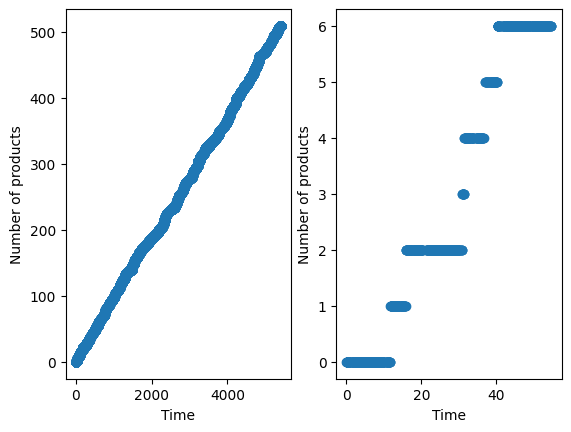

In [219]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,2,1)
plt.xlabel('Time')
plt.ylabel('Number of products')
ax2 = fig1.add_subplot(1,2,2)
plt.xlabel('Time')
plt.ylabel('Number of products')
ax1.plot(ts,np.array(N_Ps),'o')
ax2.plot(ts[0:1000],np.array(N_Ps[0:1000]),'o')
plt.savefig('Figure1_SS_100000_trials.png')

In [220]:
#convert Ls into np array, and get rid of last element to report time elapsed for coverages
Ls_np = np.array(Ls[0:-1])
#indexes where surface is vacant (L==0)
L0_ind = np.where(Ls_np == 0)
ts_np = np.array(ts)
#time elapsed in for each instance where L==0
time_L0 = np.sum(ts_np[L0_ind[0]+1]-ts_np[L0_ind[0]])
time_L0/ts_np[-1]

0.09252302224464663

In [221]:
#calculate rates
rates = np.sum(N_Ps)/np.sum(ts)

#convert Ls into np array, and get rid of last element to report time elapsed for coverages
Ls_np = np.array(Ls[0:-1])
#indexes where surface is vacant (L==0)
L0_ind = np.where(Ls_np == 0)
ts_np = np.array(ts)
#time elapsed in for each instance where L==0
time_L0 = np.sum(ts_np[L0_ind[0]+1]-ts_np[L0_ind[0]])
#normalize vacant time with total elapsed time
cov_v = time_L0/ts_np[-1]

#repeat for L=1 and L=2
L1_ind = np.where(Ls_np == 1)
ts_np = np.array(ts)
time_L1 = np.sum(ts_np[L1_ind[0]+1]-ts_np[L1_ind[0]])
cov_A = time_L1/ts_np[-1]

L2_ind = np.where(Ls_np == 2)
ts_np = np.array(ts)
time_L2 = np.sum(ts_np[L2_ind[0]+1]-ts_np[L2_ind[0]])
cov_B = time_L2/ts_np[-1]

# mean-field rates
y_A = N_A/(N_A+N_B)
rates_MF = k_AB*kA_a0/kA_d*y_A/(1+kA_a0/kA_d*y_A)

print('* coverage: '+str(cov_v))
print('A coverage: '+str(cov_A))
print('B coverage: '+str(cov_B))
print('rates: '+str(rates))
print('Mean-field rates: ' + str(rates_MF))

* coverage: 0.09252302224464663
A coverage: 0.9065593107252213
B coverage: 0.0009176670301320856
rates: 0.09369855010095553
Mean-field rates: 0.09090909090909091


In [222]:
# rates = [0.0512, .0681, 0.082, 0.0847, 0.0891, 0.0936]
# yAs = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
# theta_vs = [0.4986, 0.335, 0.201, 0.1443, 0.1101, 0.091]
# theta_As = [0.50095, 0.664, 0.7982, 0.8548, 0.888, 0.9076]

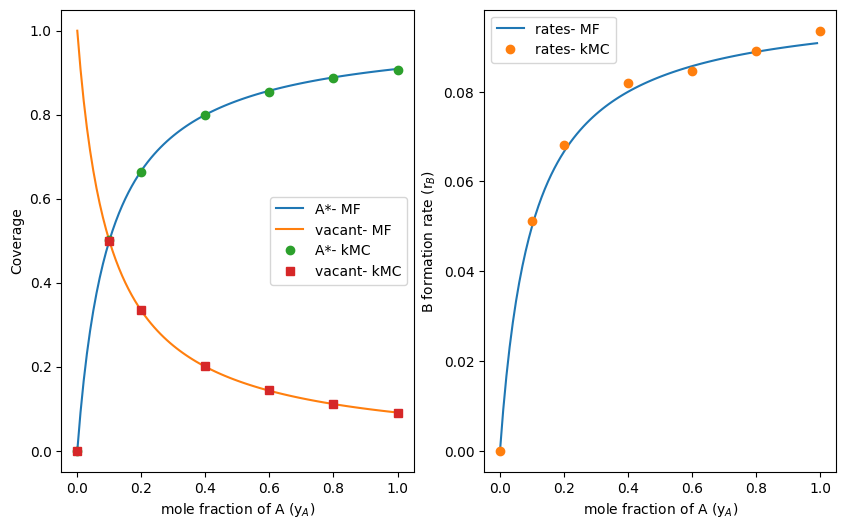

In [228]:
#plot rate
yAs = np.arange(0,1,1/100)
theta_v = 1/(1+kA_a0/kA_d*yAs)#vacant * site coverage
theta_A = theta_v*kA_a0/kA_d*yAs
#mean-field
r_B = k_AB*theta_A

#kMC results:
rates_kMC = np.array([0,0.0512, .0681, 0.082, 0.0847, 0.0891, 0.0936])
yAs_kMC = np.array([0,0.1, 0.2, 0.4, 0.6, 0.8, 1])
theta_vs_kMC = np.array([0,0.4986, 0.335, 0.201, 0.1443, 0.1101, 0.091])
theta_As_kMC = np.array([0,0.50095, 0.664, 0.7982, 0.8548, 0.888, 0.9076])

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.set_xlabel('mole fraction of A (y$_{A}$)')
ax1.set_ylabel('Coverage')
ax1.plot(yAs,theta_A,label='A*- MF')
ax1.plot(yAs,theta_v,label='vacant- MF')
ax1.plot(yAs_kMC,theta_As_kMC,'o',label='A*- kMC')
ax1.plot(yAs_kMC,theta_vs_kMC,'s',label='vacant- kMC')
ax1.legend()

ax2.plot(yAs,r_B,label='rates- MF')
ax2.plot(yAs_kMC,rates_kMC,'o',label='rates- kMC')
ax2.set_xlabel('mole fraction of A (y$_{A}$)')
ax2.set_ylabel('B formation rate (r$_{B}$)')
ax2.legend()

